<a href="https://colab.research.google.com/github/laysch/verizon-fwa/blob/main/Verizon2_Krystal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno # To visualize missing value
import plotly.graph_objects as go # To Generate Graphs
import plotly.express as px # To Generate box plot for statistical representation
%matplotlib inline

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Break Through Tech/AI Studio/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Break Through Tech/AI Studio


Get data and check features

In [ ]:
df=pd.read_csv("Area_Table_June_2021_Status_V1.csv")


<ipython-input-93-c9b5fad454bf>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("Area_Table_June_2021_Status_V1.csv")


In [ ]:
print("shape of original df:", df.shape)
df = df[df['type'] == "state"]
print("shape of new df:", df.shape)
df.head(5)

shape of original df: (23811795, 10)
shape of new df: (76293, 10)


,type,id,tech,urban_rural,tribal_non,speed,has_0,has_1,has_2,has_3more
3390534,state,01,acfosw,R,N,0.2,0,120,54,2037136
3390535,state,01,acfosw,R,T,0.2,0,0,0,282
3390536,state,01,acfosw,U,N,0.2,0,18,20,2883806
3390537,state,01,acfosw,U,T,0.2,0,0,0,1
3390538,state,02,acfosw,R,N,0.2,0,7647,13458,66268


Check for null values

In [ ]:
df.isnull().sum()


type           0
id             0
tech           0
urban_rural    0
tribal_non     0
speed          0
has_0          0
has_1          0
has_2          0
has_3more      0
dtype: int64

##Exploratory Data Analysys (EDA)


Analysis of State Data

In [ ]:
# #keep id as int for model but have write some fun to convert these ints to corresponding state strings for clear visualization purposes

# geo_df=pd.read_csv("Geography_Lookup_Table.csv")
# lookup_df = geo_df[geo_df['type'] == "state"]
# lookup_df.head(10)


Function for mapping geoid to state string


In [ ]:
# #input:array of geoids
# #output: array of state names
# #by looking up in table

# geoid_dict = dict(zip(lookup_df.geoid, lookup_df.name))
# states_array = pd.Series([geoid_dict[geoid] for geoid in df['id']])


# fig, ax = plt.subplots(figsize=(30, 8))
# states_array.hist(ax=ax)
# plt.xticks(rotation=90)


# plt.title('Distribution of States')
# plt.xlabel('State Names')
# plt.ylabel('Frequency')

# plt.show()


In [ ]:
df.drop(columns = "type", axis=1, inplace=True)
df = df.astype({'id':'int'}) #convert ids to ints

#dropping ID column for model
df.drop(['id'], axis=1, inplace=True)


<ipython-input-98-2195dccd806f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns = "type", axis=1, inplace=True)


#Tech Column
Replacing all values that has Wireless Internet with 1 and without W with 0

In [ ]:
df.replace({"tech": {"w": 1}},regex=True, inplace=True)
df.replace({"tech": {"a": 0, "c":0, "f": 0, "o": 0, "s": 0  }},regex=True, inplace=True)

##Urban/Rural
Urban as 1, Rural as 0

In [ ]:
df.replace({"urban_rural": {"U": 1, "R":0}, "tribal_non": {"T": 1, "N":0}},regex=True, inplace=True)


#Speed
Speeds with less than 1 Mbps can not have FWA

In [ ]:
df = df[df['speed'] >= 1.0]

#Providors
Combine has_0, has_1, has_2, has_3more, to 1 has_providors

In [ ]:
df['has_providers'] = df[['has_0', 'has_1', 'has_2', 'has_3more']].apply(lambda row: 1 if any(row) else 0, axis=1)
df.drop(['has_0', 'has_1', 'has_2', 'has_3more'], axis=1, inplace=True)

In [ ]:
df.head(20)

,tech,urban_rural,tribal_non,speed,has_providers
6792219,1,0,0,4.0,1
6792220,1,0,1,4.0,1
6792221,1,1,0,4.0,1
6792222,1,1,1,4.0,1
6792223,1,0,0,4.0,1
6792224,1,0,1,4.0,1
6792225,1,1,0,4.0,1
6792226,1,1,1,4.0,1
6792227,1,0,0,4.0,1
6792228,1,0,1,4.0,1


##FUZZY K-MEANS

In [ ]:
!pip install scikit-fuzzy

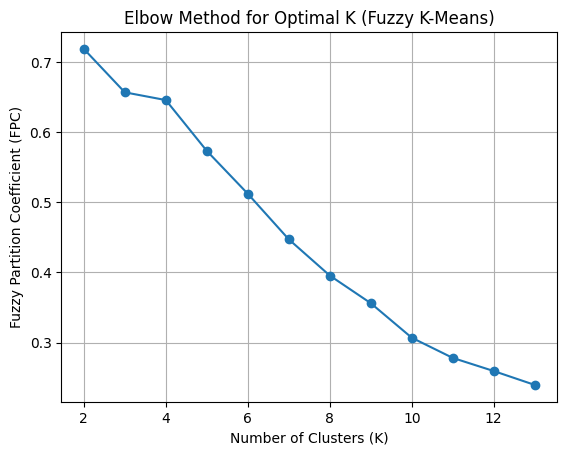

In [ ]:
import skfuzzy as fuzz
# from sklearn.preprocessing import MinMaxScaler


#using elbow method to compare Fuzzy Partition Coefficient (FPC) to find optimal K
k_range = range(2, 14)
FPC_values = []

#normalizing the speed column
# Create a MinMaxScaler instance
# scaler = MinMaxScaler()

# Reshape the feature to a 2D array (required by the scaler)
# df["speed"] = scaler.fit_transform(df["speed"].values.reshape(-1, 1))



for k in k_range:
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(df.to_numpy().T, k, 5, error=0.005, maxiter = 5000)
    FPC_values.append(fpc)


plt.plot(k_range, FPC_values, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Fuzzy Partition Coefficient (FPC)')
plt.title('Elbow Method for Optimal K (Fuzzy K-Means)')
plt.grid(True)
plt.show()

In [ ]:
k=6
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(df.to_numpy().T, k, 5, error=0.005, maxiter=5000)



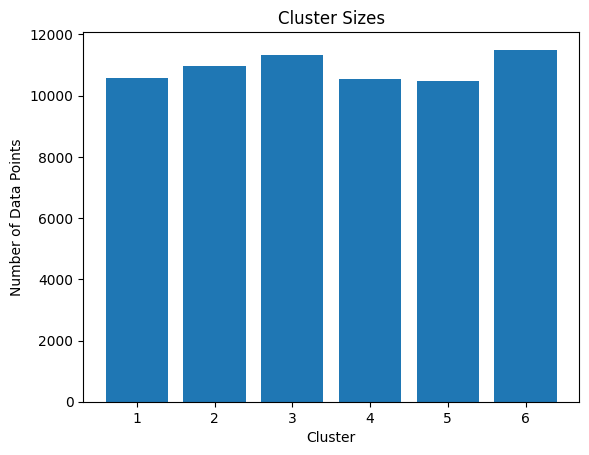

In [ ]:
cluster_sizes = u.sum(axis=1)  # Sum membership values across data points for each cluster

cluster_indices = np.arange(1, len(cluster_sizes) + 1)  # Cluster indices (1, 2, 3, ...)

# Create a bar plot to visualize cluster sizes
plt.bar(cluster_indices, cluster_sizes, tick_label=cluster_indices, align='center')
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.title('Cluster Sizes')
plt.show()



In [ ]:
for cluster_number, size in enumerate(cluster_sizes, 1):
    print(f"Cluster {cluster_number}: {round(size, 3)} data points")

Cluster 1: 10572.155 data points
Cluster 2: 10974.896 data points
Cluster 3: 11319.071 data points
Cluster 4: 10534.193 data points
Cluster 5: 10493.27 data points
Cluster 6: 11500.416 data points


In [ ]:
from sklearn.metrics import silhouette_score

# Calculate the Silhouette Score (evaluation metric, how similar data points  are to their own cluster compared to other clusters)
silhouette_avg = silhouette_score(df, u.argmax(axis=0))

print(f"Silhouette Score: {silhouette_avg}")
#note: a good score is >0.5, closer to 1 the better

Silhouette Score: 0.9234027343790961


##Characterizing the clusters


In [ ]:
feature_labels = df.columns.tolist()


# Characterize clusters using cluster centers
for cluster_number, center in enumerate(cntr):
    print(f"Cluster {cluster_number + 1} Center:")
    features = [f"{feature_labels[i]}: {value:.2f}" for i, value in enumerate(center)]
    print('\n'.join(features), "\n")

Cluster 1 Center:
tech: 0.51
urban_rural: 0.48
tribal_non: 0.32
speed: 100.00
has_providers: 0.99 

Cluster 2 Center:
tech: 0.51
urban_rural: 0.48
tribal_non: 0.30
speed: 24.99
has_providers: 0.99 

Cluster 3 Center:
tech: 0.51
urban_rural: 0.48
tribal_non: 0.30
speed: 4.05
has_providers: 0.99 

Cluster 4 Center:
tech: 0.51
urban_rural: 0.48
tribal_non: 0.34
speed: 1000.00
has_providers: 0.99 

Cluster 5 Center:
tech: 0.51
urban_rural: 0.48
tribal_non: 0.33
speed: 250.00
has_providers: 0.99 

Cluster 6 Center:
tech: 0.51
urban_rural: 0.48
tribal_non: 0.29
speed: 9.97
has_providers: 0.99 

